# Abstract

---
House Price prediction is a very popular dataset for data science competation. In this dataset 79 explanatory variables describing (almost) every aspect of residential homes in Ames and Iowa. This competition challenges compitator to predict the final price of each home.
The solution is divided in many parts.The data engineering and preprocessing is inspired from Ref 4,5,6.The Final model is author's own work. Nothing of the model is taken from any book or blog. Although in order to learn tensorflow implementation the book ref:1 helped me a lot. With out the Knowledge taken from ref:1 and 2 this kernal would not exist.
The main feature of this kernal is flexiblity. Almost every thing is tunable without coding.
The only thing I belive this kernal should have was exhaustive search implementation with I would defenitely do after this one.The plain code with less preprocessing achieved only about 0.215 public score at best.
The plain solution with out extra data preprocessing and engineering can be found in the given Github link along with othe rversions of the code. 
Github link:https://github.com/IshrakHasin/House-price/tree/master

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# Colab file upload support 

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train_ID = train['Id']
test_ID = test['Id']

# Understanding the problem label data



Understanding this correlation will help us how we should encode and fillup the respective features.Such as if some feature is very sparse and has weak correlation with sale price we will drop that feature.

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Lets try to understand the correlations with other variables

most important features relative to target
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.12

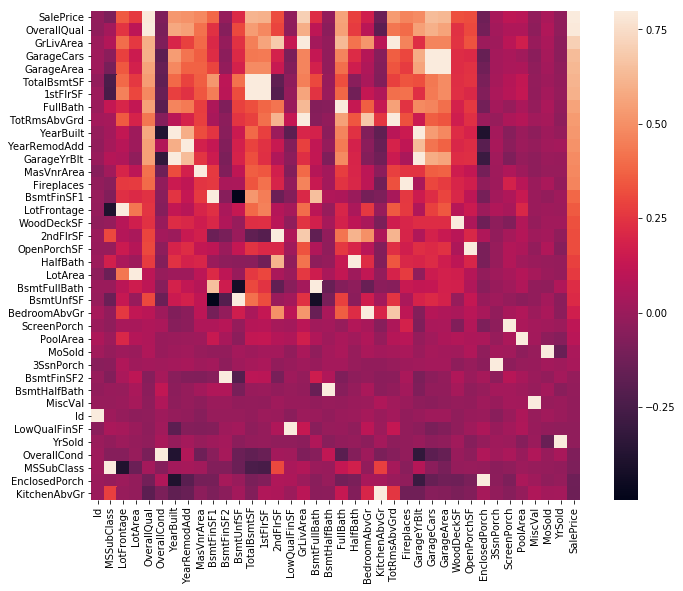

In [5]:
print("most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

# Log of Dataset
Skewed data is cumbersome and common. It’s often desirable to transform skewed data and to convert it into values between 0 and 1.Standard functions used for such conversions include Normalization, the Sigmoid, Log, Cube Root and the Hyperbolic Tangent. It all depends on what one is trying to accomplish.


In [6]:
ntrain = train.shape[0]
ntest = test.shape[0]
train["SalePrice_log"] = np.log1p(train["SalePrice"]).astype(np.float64)
train_labels_with_OT=train["SalePrice_log"]
target=train["SalePrice_log"]

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429220


We will use Matplotlib to plot our data so that we can visualize the data to understand the distribution of data, checking outilers and percept othrer patterns. 

# Justifying taking log of Data

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


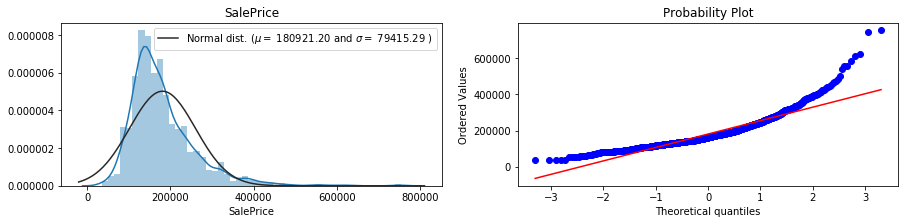

Skewness: 1.882876
Kurtosis: 6.536282


In [8]:
from scipy import stats
from scipy.stats import norm
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('SalePrice')

plt.subplot(122)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

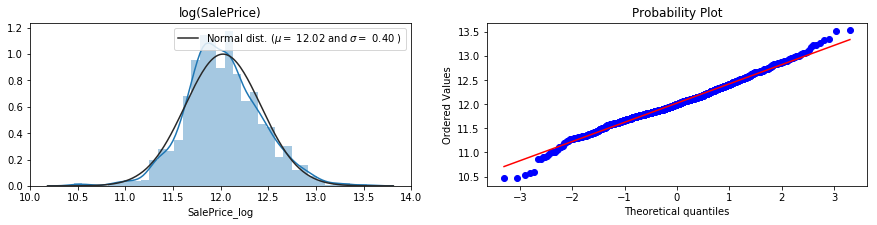

Skewness: 0.121347
Kurtosis: 0.809519


In [9]:
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train_labels_with_OT , fit=norm);

(mu, sigma) = norm.fit(train_labels_with_OT)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('log(SalePrice)')

plt.subplot(122)
res = stats.probplot(train_labels_with_OT, plot=plt)
plt.show()
print("Skewness: %f" % train["SalePrice_log"].skew())
print("Kurtosis: %f" % train["SalePrice_log"].kurt())

The log transformation can be used to make highly skewed distributions less skewed. This can be valuable both for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics.We will verify our assumption of skewness above as well.

# Numeric Features Processing

We will use .select_dtypes() method to see which columns have what type of values.

In [10]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
SalePrice_log    float64
dtype: object

# Checking corellation  again
The first five features are the most positively correlated with SalePrice and the negative valued features are the least correlated. The graph shows the most correalted features.


SalePrice        1.000000
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


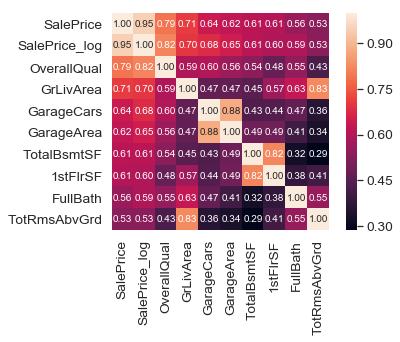

In [11]:
corr = numeric_features.corr()

print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Outliers removing

We can see that OverallQual values are integers in the range of 1 to 10. Now we will create a pivot table to inspect the relationship between OverallQual and SalePrice. We will look at the median value here. 

In [12]:
quality_pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


Now we will create a barplot to visualize the result. 

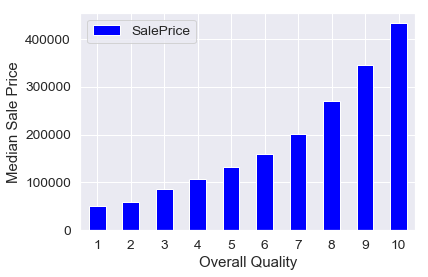

In [13]:
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

We can see that the sales price increases as the Overall Quality increases. Now we will use plt.scatter() to generate a plot and visualize the relationship between the 2nd most positively correlated attribute and out target atrribute. This scatter plot will show us the relationship between GrLivArea and SalePrice. 

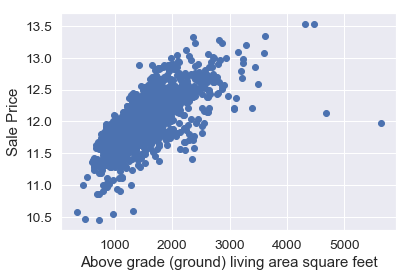

In [14]:
plt.scatter(x=train['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area square feet')
plt.show()

We will do the same for GarageArea. 

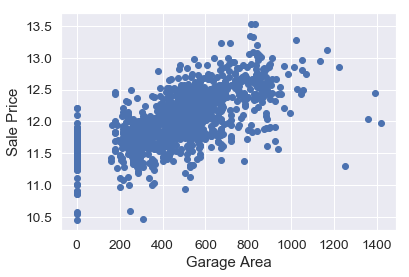

In [15]:
plt.scatter(x=train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

We can see that there many homes which don't have a garage. Here we can see a few outliers as well. Outliers can affect our regression line by pulling them further away from actual line. Now we will create a new dataframe removing those outliers. 

In [16]:
train = train[train['GarageArea'] < 1200]

Now we will plot it again

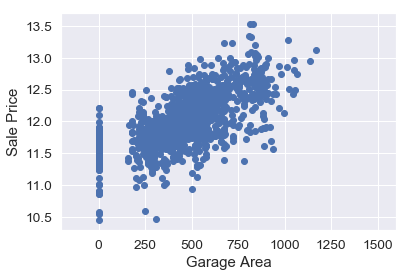

In [17]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600) # This forces the same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

# Handling Missing Data

We will now count how many values we have in the dataset. train.isnull().sum() will give us a count of null values in each column 

In [18]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
FireplaceQu,689
LotFrontage,258
GarageQual,81
GarageCond,81
GarageFinish,81


# Null Ration 

In [19]:
concated_null = (train.isnull().sum() / len(train)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio
PoolQC,99.587629
MiscFeature,96.357388
Alley,93.745704
Fence,80.687285
FireplaceQu,47.353952
LotFrontage,17.731959
GarageYrBlt,5.567010
GarageType,5.567010
GarageFinish,5.567010
GarageQual,5.567010


The houses which don't have any pools returns value NaN in Pool Quality. Now we will look at MiscFeature column. We will use MiscFeature.unique() to get the unique values. 

In [20]:
print ("Unique values are:", train.MiscFeature.unique())

Unique values are: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


We can use this information later.

# Non-numeric Features

Now we will deal with the non-numeric features. 

In [21]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1455,91,1455,1455,1455,1455,1455,1455,1455,...,1374,1374,1374,1374,1455,6,281,53,1455,1455
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1147,1450,50,921,1309,1454,1048,1378,225,1257,...,867,605,1306,1321,1335,2,157,48,1266,1196


Here counts is the number of non-null values we have, unique is the number of unique values, top are the values which are most frequent and freq shows how many of that value we have. Later we will use one-hot encoding to transform these categorical values into numerical values. 

# Feature Enginering

Anything we apply on train data will have to match the test data meaning that we will have to apply those changes on test data too. First we are going to work on street data which show if it is gravel or paved. 

In [22]:
print ("Original: \n") 
print (train.Street.value_counts(), "\n")

Original: 

Pave    1450
Grvl       5
Name: Street, dtype: int64 



We will one-hot encode the Pave and Grvl so that we can work with these data. 

In [23]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [24]:
print ('Encoded: \n') 
print (train.enc_street.value_counts())

Encoded: 

1    1450
0       5
Name: enc_street, dtype: int64


Here we encoded these categorical values into boolean values so that we can work with it.  Now we will work with SaleCondition.

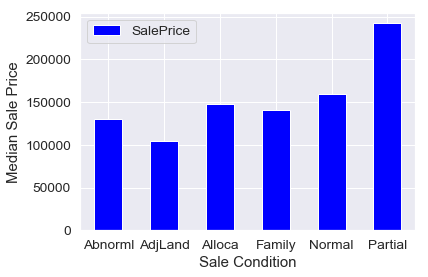

In [25]:
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

Here the partial has a higher median sale price than others. We will assign 1 to all houses which is partial otherwise 0. 

In [26]:
def encode(x): return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

Now we wil plot it.

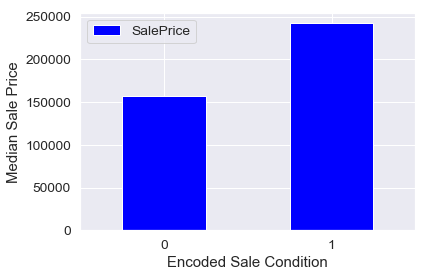

In [27]:
condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

# Missing Values

We will use interpolation for the missing values. We will assign the average of that feature to te missing values. 

In [28]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()
X_test=test.select_dtypes(include=[np.number]).interpolate().dropna()

In [29]:
X_test=X_test.drop(['Id'], axis=1)

Now we will check if all the columns have non null values. 

In [30]:
sum(data.isnull().sum() != 0)

0

In [46]:
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice_log,enc_street,enc_condition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,2,2008,208500,12.247699,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,5,2007,181500,12.109016,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,9,2008,223500,12.317171,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,2,2006,140000,11.849405,1,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,12,2008,250000,12.429220,1,0


# Model Building 

## Linear Regression using scikit learn 

y will be our target variable and x will be our feature. We will use np.log() to transform the y variables. 

In [32]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [33]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_log,enc_street,enc_condition
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,2,2008,12.247699,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,0,5,2007,12.109016,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,9,2008,12.317171,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,272,0,0,0,0,2,2006,11.849405,1,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,12,2008,12.429220,1,0


In [34]:
X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,enc_street,enc_condition
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,120,0,0,6,2010,1.0,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,36,0,0,0,0,12500,6,2010,1.0,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,34,0,0,0,0,0,3,2010,1.0,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,36,0,0,0,0,0,6,2010,1.0,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,82,0,0,144,0,0,1,2010,1.0,0


We will now use train_test_split() to split the data into training set and test set

In [35]:
from sklearn.model_selection import train_test_split
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X, y, random_state=23, test_size=.20)

We will first create a LinearRegression Model and instantiate it. 

In [36]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

Next we will fit the model to our test set. 

In [37]:
model = lr.fit(X_train_val, y_train_val)

Now we will evaluate its performance using r^2 (r-square) method. 

In [38]:
print ("R^2 is: \n", model.score(X_test_val, y_test_val))

R^2 is: 
 0.9999999999972207


Now we will consider RMSE to calculate our error. model.predict() will return a set of predictions given a set of predictors. We will feed the mean-squared-error() function to calculate the rmse.

In [39]:
predictions = model.predict(X_test_val)
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_test_val, predictions))

RMSE is: 
 4.097009519573724e-13


We can view this relationship with scatterplot

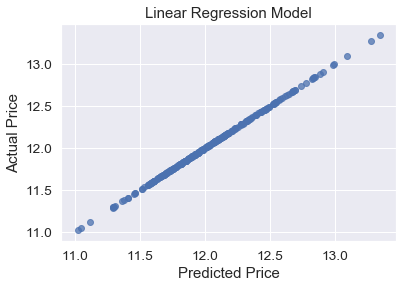

In [40]:
actual_values = y_test_val
plt.scatter(predictions, actual_values, alpha=.75, color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

## Improving the model

We used ridge regularization to decrease the effect of less important features. We used parameter 'alpha' to control the strength of the regularization. 

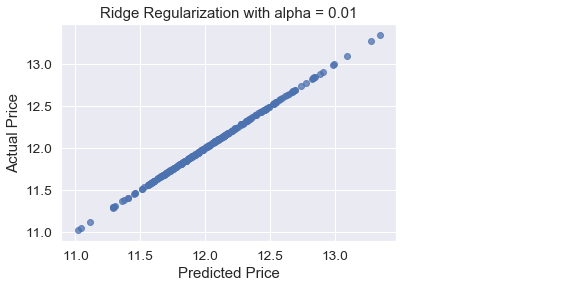

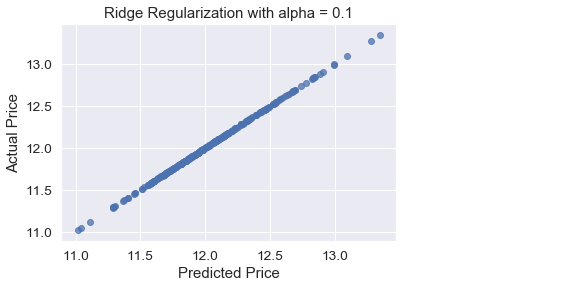

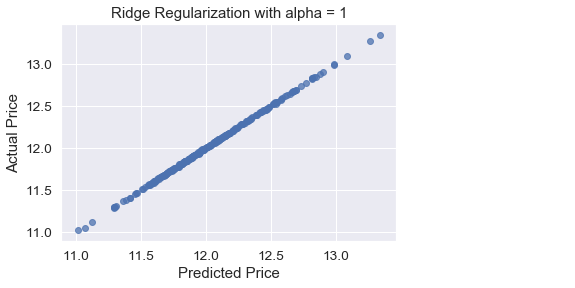

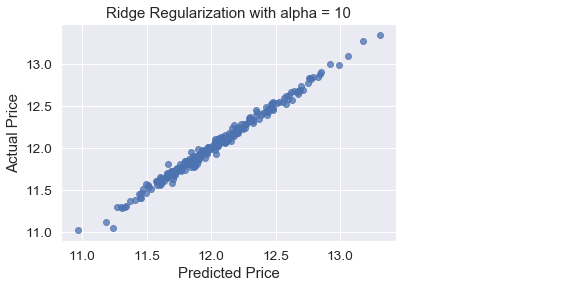

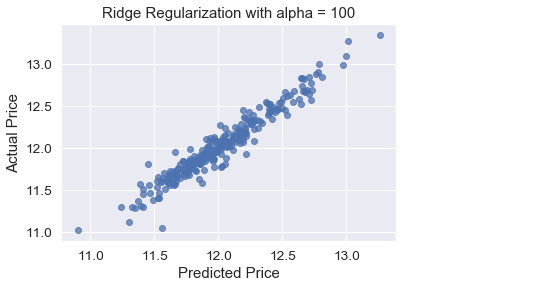

In [41]:
for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train_val, y_train_val)
    preds_ridge = ridge_model.predict(X_test_val)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(X_test_val, y_test_val),
                    mean_squared_error(y_test_val, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

Kaggle Submission

In [42]:
test.shape

(1459, 82)

In [43]:
submission = pd.DataFrame()
submission['Id'] = test.Id
feats = test.select_dtypes(include=[np.number]).drop(['Id'], axis=1).interpolate()
predictions = model.predict(feats)
final_predictions = np.exp(predictions)
print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])
submission['SalePrice'] = final_predictions
submission.head()
submission.to_csv('Kaggle_Houseprice_Linear_Regression.csv', index=False)

ValueError: shapes (1459,38) and (39,) not aligned: 38 (dim 1) != 39 (dim 0)

## Submission result

# Deep Neural Network using Tensorflow

In [38]:
X_train_val

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_log,enc_street,enc_condition
373,20,79.000000,10634,5,6,1953,1953,0.0,428,180,...,0,0,0,0,0,11,2009,11.719948,1,0
83,20,80.000000,8892,5,5,1960,1960,66.0,0,0,...,0,0,0,0,0,7,2007,11.748005,1,0
925,20,86.000000,15611,5,6,1977,1977,0.0,767,93,...,0,0,0,0,0,3,2008,12.072547,1,0
345,50,65.000000,6435,6,5,1939,1950,0.0,0,0,...,0,0,0,0,0,10,2006,11.850832,1,0
1233,20,62.500000,12160,5,5,1959,1959,180.0,1000,0,...,0,0,0,0,0,5,2010,11.863589,1,0
207,20,51.666667,12493,4,5,1960,1960,0.0,419,306,...,0,0,0,0,0,4,2008,11.856522,1,0
314,70,60.000000,9600,7,7,1925,1990,0.0,16,0,...,234,0,0,0,0,8,2006,12.089544,1,0
813,20,75.000000,9750,6,6,1958,1958,243.0,608,0,...,275,0,0,0,500,4,2007,11.969724,1,0
927,60,88.000000,9900,7,5,1968,1968,342.0,552,0,...,0,0,0,0,0,4,2008,12.078245,1,0
1050,20,73.000000,8993,7,5,2007,2007,0.0,0,0,...,0,0,0,0,0,8,2007,12.080997,1,1


Here I initialized a Session so that I we run tensorflow oprations later. 

Here I converted the dataframe to numpy array. 

Here a layer is created and it produces a single output by taking a bunch of inputs. 

Here the loss is calculated.

Gradient Descent was used to minimize the loss. 

In [63]:
tf.reset_default_graph()

#Learning rate with schedular
learning_rate=0.1

In [64]:
num_steps =5000
beta = .005
hidden_1 = 16 
hidden_2 = 8
hidden_3 = 4 
input_dim = X_train_val.shape[1]
output_dim = 1  
X_tf = tf.placeholder("float" ) 
y_tf = tf.placeholder("float" ) 

This is to see the progression of our training by printing the loss value. 

I will try to fix this part and submit again.

In [65]:
weights = {'w1': tf.Variable(tf.random_normal([input_dim, hidden_1])),  
           'w2': tf.Variable(tf.random_normal([hidden_1, hidden_2])),  
           'w3': tf.Variable(tf.random_normal([hidden_2, hidden_3])), 
           'out': tf.Variable(tf.random_normal([hidden_3, output_dim ])) }

biases = {'b1': tf.Variable(tf.random_normal([hidden_1])),
          'b2': tf.Variable(tf.random_normal([hidden_2])),
          'b3': tf.Variable(tf.random_normal([hidden_3])),
          'out': tf.Variable(tf.random_normal([output_dim])) } 

In [66]:
 def ann_model(X_val): 
        layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1' ]) 
        layer_1 = tf.nn.relu(layer_1) 
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2) 
        layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3']) 
        layer_3 = tf.nn.relu(layer_3)
        layer_out = tf.add(tf.matmul(layer_3, weights['out']), biases ['out']) 
        return layer_out 

In [67]:
# Model Construct 
model = ann_model(X_tf) 
# Mean Squared Error cost function
cost = tf.reduce_mean(tf.square(y_tf - model)) 
regularizer_1 = tf.nn.l2_loss(weights['w1']) 
regularizer_2 = tf.nn.l2_loss(weights['w2']) 
regularizer_3 = tf.nn.l2_loss(weights['w3']) 
cost = tf.reduce_mean(cost + beta*regularizer_1 + beta*regularizer_2 
                      + regularizer_3)

In [68]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) .minimize(cost)

In [69]:
init = tf.global_variables_initializer() 

In [70]:
saver = tf.train.Saver() 

In [71]:
with tf.Session() as sess: 
        sess.run(init) 
        for i in range(num_steps): 
            sess.run(optimizer, feed_dict={X_tf:X, y_tf:y})  
            if (i+1)%100 == 0: 
                 loss_val = cost.eval(feed_dict={X_tf: X_test_val, y_tf: y_test_val})
                 print("batch no : ",i+1,"Loss",loss_val) 
        save_path = saver.save(sess, "/tmp/model.ckpt") 
        print("Model saved in path: %s" % save_path) 
        pred = sess.run(model, feed_dict={X_tf: X_test}) 

batch no :  100 Loss 151.67471
batch no :  200 Loss 151.31744
batch no :  300 Loss 150.84291
batch no :  400 Loss 150.2684
batch no :  500 Loss 149.6022
batch no :  600 Loss 148.84933
batch no :  700 Loss 148.01285
batch no :  800 Loss 147.09474
batch no :  900 Loss 146.09631
batch no :  1000 Loss 145.01833
batch no :  1100 Loss 143.86119
batch no :  1200 Loss 142.62503
batch no :  1300 Loss 141.30984
batch no :  1400 Loss 139.91556
batch no :  1500 Loss 138.44191
batch no :  1600 Loss 136.8887
batch no :  1700 Loss 135.25566
batch no :  1800 Loss 133.54265
batch no :  1900 Loss 131.74948
batch no :  2000 Loss 129.87611
batch no :  2100 Loss 127.92264
batch no :  2200 Loss 125.88928
batch no :  2300 Loss 123.77642
batch no :  2400 Loss 121.58469
batch no :  2500 Loss 119.3149
batch no :  2600 Loss 116.96811
batch no :  2700 Loss 114.54568
batch no :  2800 Loss 112.04932
batch no :  2900 Loss 109.48096
batch no :  3000 Loss 106.843185
batch no :  3100 Loss 104.13831
batch no :  3200 Los

InvalidArgumentError: Matrix size-incompatible: In[0]: [1459,38], In[1]: [39,16]
	 [[node MatMul (defined at <ipython-input-66-d6415ac443bb>:2)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_0_0/_71, Variable/read)]]

Caused by op 'MatMul', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-67-afb8a72c3978>", line 2, in <module>
    model = ann_model(X_tf)
  File "<ipython-input-66-d6415ac443bb>", line 2, in ann_model
    layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1' ])
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2057, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4560, in mat_mul
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Matrix size-incompatible: In[0]: [1459,38], In[1]: [39,16]
	 [[node MatMul (defined at <ipython-input-66-d6415ac443bb>:2)  = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_Placeholder_0_0/_71, Variable/read)]]


In [60]:
pred

NameError: name 'pred' is not defined

In [71]:
prediction = np.expm1(pred) 

In [72]:
prediction.shape

(1459, 1)

In [ ]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = prediction

sub.to_csv('Final With Early stopping.csv',index=False)

In [96]:
m_train,n_train=X_train_val.shape
m_val,n_val=X_test_val.shape
m_test,n_test=X_test.shape

In [97]:
# hidden layers neuron numbers, batchsize and epoch number
tf.reset_default_graph()

n_inputs = n_train
n_hidden1 = 128
n_hidden2 = 68
n_hidden3=32
n_hidden4=16
n_hidden5=8
n_hidden6=4
n_outputs = 1
n_epochs = 5000 
batch_size = 32

In [99]:
#Place holder initiallizations
X = tf.placeholder(tf.float64,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float64,shape=(None), name="y")

In [100]:
training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate_X = 0.0
dropout_rate_1=0.5
dropout_rate_2=0.2
dropout_rate_3=0.2
dropout_rate_4=0.2
dropout_rate_5=0.2
dropout_rate_6=0.0
X_drop = tf.layers.dropout(X, dropout_rate_X, training=training)
he_init = tf.variance_scaling_initializer()

In [101]:
#max norn fuctions

def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

#Threshold tuning option
max_norm_reg = max_norm_regularizer(threshold=4.0)


In [102]:
#Batch normalizaion function and He initializer
from functools import partial
batch_norm_momentum=0.9

he_init = tf.variance_scaling_initializer()

Custom_batch_normalized_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

Custum_dense_layer = partial(
            tf.layers.dense,kernel_initializer=he_init, use_bias=True, bias_initializer=tf.zeros_initializer(),
kernel_regularizer=max_norm_reg)

In [103]:


with tf.name_scope("dnn"):
    
    #layer1   
    hidden1 =Custum_dense_layer(X, n_hidden1,name="hidden1")
    bn1 = Custom_batch_normalized_layer(hidden1)
    hidden1_bn = tf.nn.relu(bn1)
    hidden1_drop = tf.layers.dropout(hidden1_bn, dropout_rate_1, training=training)

    #layer2   
    hidden2 =Custum_dense_layer(hidden1_drop, n_hidden2,name="hidden2")
    bn2 = Custom_batch_normalized_layer(hidden2)
    hidden2_bn = tf.nn.relu(bn2)
    hidden2_drop = tf.layers.dropout(hidden2_bn, dropout_rate_2, training=training)
    
    #layer3   
    hidden3 =Custum_dense_layer(hidden2_drop, n_hidden3,name="hidden3")
    bn3 = Custom_batch_normalized_layer(hidden3)
    hidden3_bn = tf.nn.relu(bn3)
    hidden3_drop = tf.layers.dropout(hidden3_bn, dropout_rate_3, training=training)
    
    #layer4
    hidden4 =Custum_dense_layer(hidden3_drop, n_hidden4,name="hidden4")
    bn4 = Custom_batch_normalized_layer(hidden4)
    hidden4_bn = tf.nn.relu(bn4)
    hidden4_drop = tf.layers.dropout(hidden4_bn, dropout_rate_4, training=training)
    #layer5
    hidden5 = Custum_dense_layer( hidden4_drop,n_hidden5,name="hidden5")
    bn5= Custom_batch_normalized_layer(hidden5)
    hidden5_n = tf.nn.elu(bn5)
    hidden5_drop= tf.layers.dropout(hidden5_n, dropout_rate_5, training=training)
    #layer6
    hidden6 = Custum_dense_layer( hidden5_drop,n_hidden6,name="hidden6")
    bn6= Custom_batch_normalized_layer(hidden6)
    hidden6_n = tf.nn.elu(hidden6)
    hidden6_drop= tf.layers.dropout(hidden6_n,dropout_rate_6, training=training)

    
    #output
    y_pred_before_BN = Custum_dense_layer(hidden6_drop,n_outputs,name="outputs")
    y_pred=Custom_batch_normalized_layer( y_pred_before_BN)







In [104]:
#Loss calculation and optimizer

mse = tf.losses.mean_squared_error(y,y_pred)



learning_rate=0.1
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    #training_op = optimizer.minimize(mse,global_step=global_step)
     training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()

In [105]:
#batch making and shuffling
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
#Clipping gradient and saver object
saver = tf.train.Saver()
clip_all_weights=tf.get_collection("max_norm")

In [ ]:
#Session with Early stopping mechanism

max_checks_without_progress = 1500
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        #for X_batch, y_batch in shuffle_batch(X_train_val, y_train_val, batch_size):
        sess.run(training_op, feed_dict={X: X_train_val, y:  y_train_val})
        sess.run(clip_all_weights)

        loss_val = mse.eval(feed_dict={X: X_test_val, y: y_test_val})
        
        
        #Check whether to stop or not
        if loss_val < best_loss:
            save_path = saver.save(sess,"./Final_Certairi.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        
        #printing at run time
        if epoch %100==0:
            #acc_batch = mse.eval(feed_dict={X: X_batch, y: y_batch})
            acc_val = mse.eval(feed_dict={X: X_test_val, y: y_test_val})
            
            
            
            print("Epoch_number",epoch, "Val error:", acc_val)
    pred=y_pred.eval(feed_dict={X: X_test})

                
with tf.Session() as sess:
    saver.restore(sess, "./Final_Certairi.ckpt")
    pred_res=y_pred.eval(feed_dict={X: X_test})

Epoch_number 0 Val error: 463660.66
Epoch_number 100 Val error: 0.36504066
Epoch_number 200 Val error: 0.29563874
Epoch_number 300 Val error: 0.1624535
Epoch_number 400 Val error: 0.15626824
Epoch_number 500 Val error: 0.15427242
Epoch_number 600 Val error: 0.15361577
Epoch_number 700 Val error: 0.15334576
Epoch_number 800 Val error: 0.15321544
Epoch_number 900 Val error: 0.15313043
Epoch_number 1000 Val error: 0.1530501
